In [109]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

<AxesSubplot:xlabel='time'>

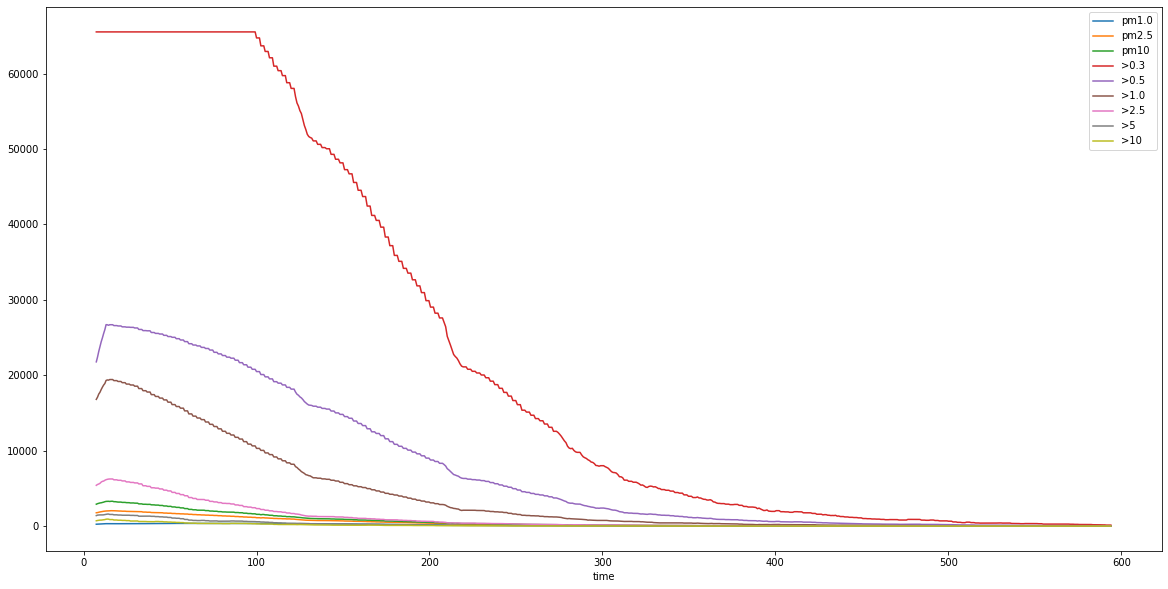

In [110]:
#df = pd.read_csv('20220623_4_ArcticP14_4_ikea_100_pwr.csv')
#df = pd.read_csv('20220623_2_iPPC3000_2_ikea_100_pwr.csv')
#df = pd.read_csv('20220623_2_iPPC3000_2_ikea_66_pwr.csv')
#df = pd.read_csv('20220623_Levoit400s_4_spd.csv')
#df = pd.read_csv('20220623_ACH_vd.csv')
#df = pd.read_csv('20220624_GermGuardian_CDAP4500BCA_5_spd.csv')
#df = pd.read_csv('20220624_4_A12x25_3_Starkvind_100_pwr_0_days.csv')
df = pd.read_csv('20220626_2_NF-P12_redux1700PWM_2_Starkvind_100_pwr.csv')
df.set_index('time').plot(kind='line', figsize=(20,10))

<AxesSubplot:xlabel='time'>

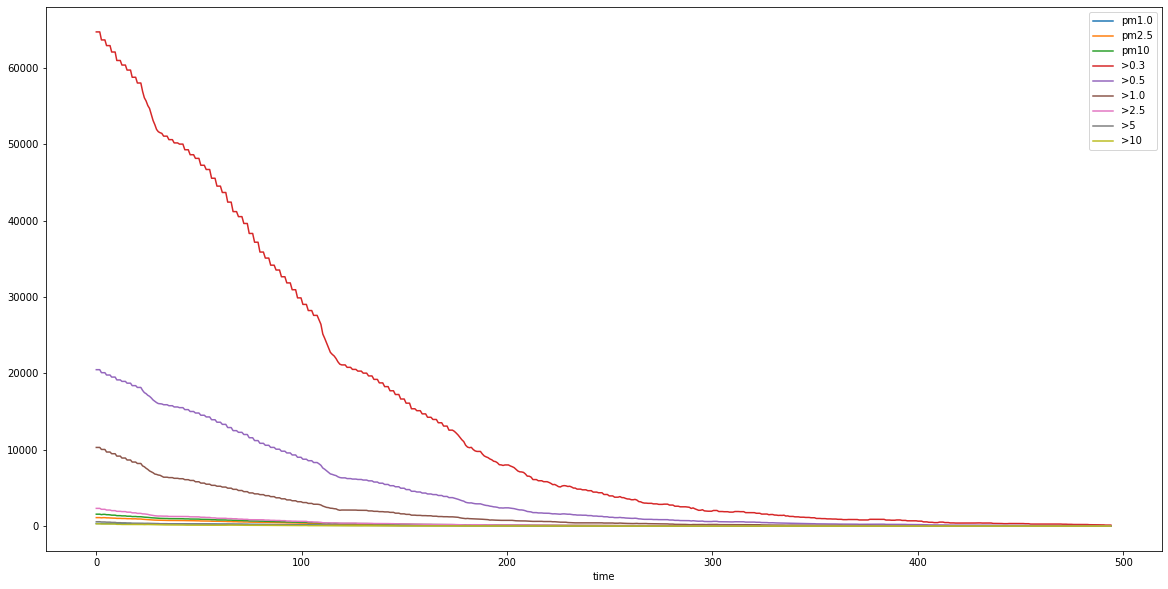

In [111]:
# cut off all records before >0.3um was below 65535, sensor values may be incorrect before then since it's at max 16-bit unsigned int
drop_start_idx = df[df['>0.3'] < 65535].index[0]
if drop_start_idx != 0:
    df = df.tail(-drop_start_idx)
# adjust times according to new t0 after tail was run
df.time = df.time - df.time.iloc[0]
df.index = df.index - df.index[0]
df.set_index('time').plot(kind='line', figsize=(20,10))

<AxesSubplot:xlabel='time'>

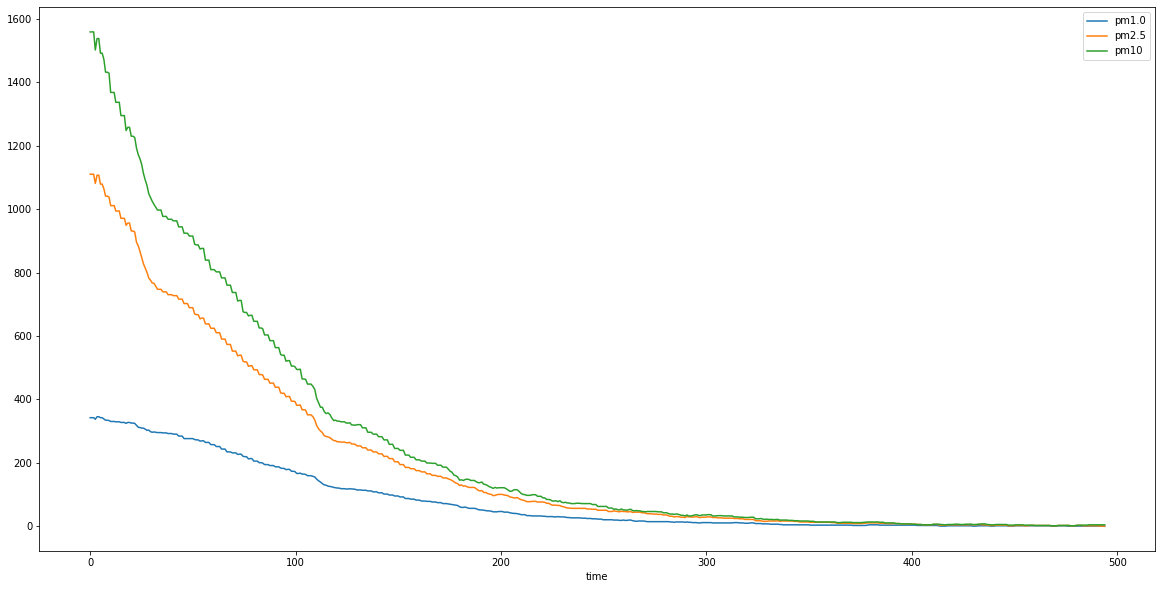

In [112]:
df_pm = df[['time', 'pm1.0', 'pm2.5', 'pm10']].copy()
df_pm.set_index('time').plot(kind='line', figsize=(20,10))

ACH: 43.67152011652672
stddev: 0.10351649903226917


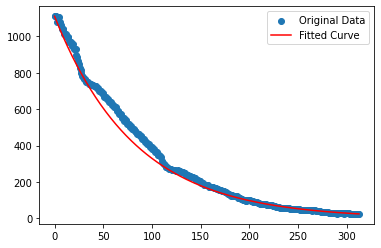

In [113]:
df_pm25 = df[['time','pm2.5']].copy()

# cut all values after pm2.5 gets to about 25, they have an outsized impact on fit after converting to log
lt25_iloc = df_pm25[df_pm25['pm2.5'] < 25].index[0]
df_pm25 = df_pm25[:lt25_iloc]

# see equation (S1) from supplemental material here: https://www.tandfonline.com/doi/full/10.1080/02786826.2022.2054674?scroll=top&needAccess=true
C_bgd = 0
C_pt0 = df_pm25['pm2.5'][df.index[0]]

## logarithmic function
def func(t, ACH):
    # divide by 3600 to convert seconds to hours
    return C_bgd + C_pt0 * np.exp(-ACH*t / 3600)

def linear_func(t, ACH):
    return np.log(C_pt0) - ACH * t / 3600

popt, pcov = curve_fit(linear_func, df_pm25.time, np.log(df_pm25['pm2.5']))
print('ACH: {}'.format(popt[0]))
print('stddev: {}'.format(np.sqrt(np.diag(pcov))[0]))
plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

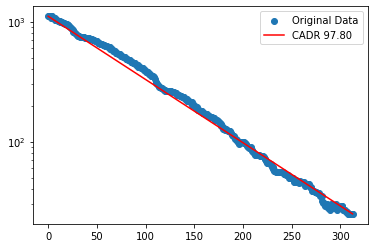

In [114]:
# Determine ACH_vd in trial with air cleaner off, it is ACH due to room ventilation (v) and particle deposition (d)
ACH_vd = 3.658926048639792
ACH_f = popt[0] - ACH_vd
# volume of room
V_r = (59. / 12) * (59. / 12) * (72.8 / 12) # this is in cubic feet
CADR = V_r * ACH_f / 60 # units of ACH are 1/h, divide by 60 to convert to 1/minutes so CADR is in cubic feet per minute

plt.figure()
plt.scatter(df_pm25.time, df_pm25['pm2.5'], label="Original Data")
plt.plot(df_pm25.time, func(df_pm25.time, *popt), 'r-', label="CADR {:0.2f}".format(CADR))
plt.yscale('log')
plt.legend()
plt.show()